In [1]:
"""
# %% [markdown]
# <a href="https://colab.research.google.com/github/wigginno/large-scale-lin-kernighan/blob/main/toy_lkh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# %% [markdown]
# # Lin-Kernighan-Helsgaun (LKH) Tour Improvement Implementation
# 
# ## Overview
# 
# The Lin-Kernighan algorithm is one of the most effective heuristic methods for solving the Traveling Salesman Problem (TSP).
# It works by making a sequence of edge exchanges that progressively improve the tour length. The key ideas are:
#
# 1. Start with any valid tour
# 2. Look for sequences of edge exchanges that can improve the tour length
# 3. When a better tour is found, make those exchanges and continue searching
# 4. Stop when no more improving sequences can be found
#
# This implementation is inspired by Keld Helsgaun's LKH variant, which is considered the most effective 
# implementation of Lin-Kernighan. The key differences in this implementation are:
#
# - Uses a simple array-based tour representation instead of a splay tree (making it O(n) for exchanges)
# - Limited to problems under 5000 cities due to the simpler data structure
# - Precomputes feasible edge exchange sequences up to 5-opt moves
# - Uses a basic candidate set generation based on Delaunay triangulation and nearest neighbors
#
# ## Implementation Details
#
# The core algorithm works by:
#
# 1. For each city in the tour:
#    - Look for sequences of edge exchanges starting from that city
#    - Try progressively longer sequences (2-opt up to 5-opt) until an improvement is found
#    - Apply the first improving sequence found
# 
# 2. Edge exchanges are represented as "alternating trails" - sequences of edges where we 
#    alternate between edges to remove and edges to add
#
# 3. The implementation precomputes all feasible ways to perform the edge exchanges using
#    sequences of 2-opt moves (tour segment reversals)
#
# 4. Candidate edges for each city are precomputed using nearest neighbors and the Delaunay
#    triangulation to limit the search space
#
# The full C++ implementation will use a splay tree with reversal bits for O(log n) exchanges,
# making it practical for much larger problems.
#
# Required packages:
# - numpy: For efficient array operations
# - matplotlib: For visualizing tours
# - scipy: For Delaunay triangulation
# - numba: For JIT compilation of performance-critical code
# 
# ## Usage Instructions
# 
# 1. Run all cells in sequence
# 2. Allow ~20-25 minutes for precomputation of edge exchange sequences
# 3. View benchmark results in section 4
#
# Note: The precomputation time is due to finding all feasible ways to perform edge exchanges.
# This is included here for completeness but would typically be done once and saved.
"""

: 

In [2]:
import pickle
from time import perf_counter_ns
from itertools import permutations
from glob import glob
import os
import re
import os.path as osp
import requests
import gzip
import tarfile
from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from numba import njit
from numpy import typing as npt

: 

## 1. Precomputation: Derive information about feasible edge exchanges

*Identify feasible "alternating trails" (for 2, 3, 4, and 5-opt moves) and which sequences of 2-Opt moves (tour segment reversals) can be used to apply these trails.*

In [3]:
@njit
def replace_neighbor(tour_neighbors: npt.NDArray[np.int32], node: int, old_neighbor: int, new_neighbor: int):
    """Update the neighbor array when performing edge exchanges.

    Args:
        tour_neighbors: Array storing the two neighbors for each node in the tour
        node: The node whose neighbor needs to be updated
        old_neighbor: The previous neighbor to be replaced
        new_neighbor: The new neighbor to add
    """
    if tour_neighbors[node][0] == old_neighbor:
        tour_neighbors[node][0] = new_neighbor
    elif tour_neighbors[node][1] == old_neighbor:
        tour_neighbors[node][1] = new_neighbor

@njit
def trail_is_feasible(tour: npt.NDArray[np.int32], trail: npt.NDArray[np.int32]):
    """Check if a sequence of edge exchanges (trail) results in a valid tour.

    A trail is a sequence of edges where we alternate between edges to remove
    and edges to add. This function verifies that applying these exchanges
    results in a single connected cycle visiting all nodes exactly once.

    Args:
        tour: Current tour as array of node indices
        trail: Sequence of nodes defining the edge exchanges

    Returns:
        bool: True if the trail results in a valid tour, False otherwise
    """
    length = len(trail)

    if length not in (4, 6, 8, 10):
        return False

    neighbors = np.empty((len(tour), 2), dtype=np.int32)

    # Build neighbor array for current tour
    for i, node in enumerate(tour):
        neighbors[node][0] = tour[(i + len(tour) - 1) % len(tour)]
        neighbors[node][1] = tour[(i + 1) % len(tour)]

    # Apply the edge exchanges defined by the trail
    for odd_index in range(1, length, 2):
        node = trail[odd_index]
        old_neighbor = trail[odd_index - 1]
        new_neighbor = trail[(odd_index + 1) % length]
        new_neighbors_old_neighbor = trail[(odd_index + 2) % length]
        replace_neighbor(neighbors, node, old_neighbor, new_neighbor)
        replace_neighbor(neighbors, new_neighbor, new_neighbors_old_neighbor, node)

    # Verify result is a single cycle by traversing from node 0
    n_visited = 0
    visited = np.zeros(len(tour), dtype=np.bool_)
    cur_node = 0
    while True:
        n_visited += 1
        if n_visited == len(tour):
            return True
        visited[cur_node] = True
        neighbor_1, neighbor_2 = neighbors[cur_node]
        if not visited[neighbor_1]:
            cur_node = neighbor_1
        elif not visited[neighbor_2]:
            cur_node = neighbor_2
        else:
            return False

@njit
def get_feasible_trails(trail_permutations: npt.NDArray[np.int32]):
    """Find all valid edge exchange sequences from a set of candidate permutations.

    Args:
        trail_permutations: Array of candidate node sequences to test

    Returns:
        Array of valid edge exchange sequences that result in proper tours
    """
    length = trail_permutations.shape[1]

    if length not in (4, 6, 8, 10):
        return np.empty((0, 0), dtype=np.int32)

    mask = np.ones(len(trail_permutations), dtype=np.bool_)

    dummy_tour = np.arange(32, dtype=np.int32)

    for i, trail in enumerate(trail_permutations):
        # Check that consecutive even-indexed nodes are neighbors in current tour
        for even_index in range(0, length, 2):
            if abs(trail[even_index] - trail[even_index + 1]) not in (1, 31):
                mask[i] = False
                break
        if mask[i]:
            # Check that odd-indexed nodes aren't neighbors
            for odd_index in range(1, length, 2):
                if abs(trail[odd_index] - trail[(odd_index + 1) % length]) in (1, 31):
                    mask[i] = False
                    break

        if mask[i]:
            mask[i] = trail_is_feasible(dummy_tour, trail)

    return trail_permutations[mask]

@njit
def get_trail_keys(trails: npt.NDArray[np.int32]):
    length = trails.shape[1]
    if length not in (4, 6, 8, 10):
        return np.empty((0, 0), dtype=np.int32)

    keys = np.zeros((len(trails), trails.shape[1] - 1), dtype=np.int32)

    for i, trail in enumerate(trails):
        for higher_index in range(1, len(trail)):
            for lower_index in range(higher_index):
                if trail[higher_index] > trail[lower_index]:
                    keys[i, higher_index - 1] += 1

    return keys

@njit
def transform_trails_for_dummy_tours(trails: npt.NDArray[np.int32]):
    length = trails.shape[1]

    if length not in (4, 6, 8, 10):
        return

    for trail in trails:
        for edge_idx in range(length // 2):
            i = edge_idx * 2
            j = i + 1
            if trail[i] == 0 and trail[j] == len(trail) - 1:
                trail[j] = 31
            elif trail[i] == len(trail) - 1 and trail[j] == 0:
                trail[i] = 31
            elif trail[i] < trail[j]:
                trail[i] = trail[i] * 3 + 3
                trail[j] = trail[i] + 1
            else:
                trail[j] = trail[j] * 3 + 3
                trail[i] = trail[j] + 1

In [4]:
trail_4_permutations = np.fromiter(permutations(range(4)), dtype=np.dtype((np.int32, 4)))
trail_6_permutations = np.fromiter(permutations(range(6)), dtype=np.dtype((np.int32, 6)))
trail_8_permutations = np.fromiter(permutations(range(8)), dtype=np.dtype((np.int32, 8)))
trail_10_permutations = np.fromiter(permutations(range(10)), dtype=np.dtype((np.int32, 10)))

# Start with the smallest input to warm up the JIT-compiled functions
transform_trails_for_dummy_tours(trail_4_permutations)
trails_4 = get_feasible_trails(trail_4_permutations)
trails_4_keys = get_trail_keys(trails_4)

In [5]:
transform_trails_for_dummy_tours(trail_6_permutations)
transform_trails_for_dummy_tours(trail_8_permutations)
transform_trails_for_dummy_tours(trail_10_permutations)

trails_6 = get_feasible_trails(trail_6_permutations)
trails_8 = get_feasible_trails(trail_8_permutations)
trails_10 = get_feasible_trails(trail_10_permutations)

trails_6_keys = get_trail_keys(trails_6)
trails_8_keys = get_trail_keys(trails_8)
trails_10_keys = get_trail_keys(trails_10)

trails_4_unique_idx = np.sort(np.unique(trails_4_keys, axis=0, return_index=True)[1])
trails_6_unique_idx = np.sort(np.unique(trails_6_keys, axis=0, return_index=True)[1])
trails_8_unique_idx = np.sort(np.unique(trails_8_keys, axis=0, return_index=True)[1])
trails_10_unique_idx = np.sort(np.unique(trails_10_keys, axis=0, return_index=True)[1])

trails_4 = trails_4[trails_4_unique_idx]
trails_6 = trails_6[trails_6_unique_idx]
trails_8 = trails_8[trails_8_unique_idx]
trails_10 = trails_10[trails_10_unique_idx]

trails_4_keys = trails_4_keys[trails_4_unique_idx]
trails_6_keys = trails_6_keys[trails_6_unique_idx]
trails_8_keys = trails_8_keys[trails_8_unique_idx]
trails_10_keys = trails_10_keys[trails_10_unique_idx]

print(trails_4.shape, trails_6.shape, trails_8.shape, trails_10.shape)

(8, 4) (48, 6) (320, 8) (2960, 10)


In [ ]:
# Build multidimensional arrays for accessing exchange index for each possible trail. -1 means the trail is not feasible

trail_4_exchange_index = np.full((2, 3, 4), -1, dtype=np.int16)
trail_6_exchange_index = np.full((2, 3, 4, 5, 6), -1, dtype=np.int16)
trail_8_exchange_index = np.full((2, 3, 4, 5, 6, 7, 8), -1, dtype=np.int16)
trail_10_exchange_index = np.full((2, 3, 4, 5, 6, 7, 8, 9, 10), -1, dtype=np.int16)

trail_4_exchange_index[trails_4_keys[:, 0], trails_4_keys[:, 1], trails_4_keys[:, 2]] = np.arange(len(trails_4), dtype=np.int16)
trail_6_exchange_index[trails_6_keys[:, 0], trails_6_keys[:, 1], trails_6_keys[:, 2], trails_6_keys[:, 3], trails_6_keys[:, 4]] = np.arange(len(trails_6), dtype=np.int16)
trail_8_exchange_index[trails_8_keys[:, 0], trails_8_keys[:, 1], trails_8_keys[:, 2], trails_8_keys[:, 3], trails_8_keys[:, 4], trails_8_keys[:, 5], trails_8_keys[:, 6]] = np.arange(len(trails_8), dtype=np.int16)
trail_10_exchange_index[trails_10_keys[:, 0], trails_10_keys[:, 1], trails_10_keys[:, 2], trails_10_keys[:, 3], trails_10_keys[:, 4], trails_10_keys[:, 5], trails_10_keys[:, 6], trails_10_keys[:, 7], trails_10_keys[:, 8]] = np.arange(len(trails_10), dtype=np.int16)

# Sanity check for mistakes
assert trail_4_exchange_index.size == len(trail_4_permutations) and np.sum(trail_4_exchange_index != -1) == len(trails_4)
assert trail_6_exchange_index.size == len(trail_6_permutations) and np.sum(trail_6_exchange_index != -1) == len(trails_6)
assert trail_8_exchange_index.size == len(trail_8_permutations) and np.sum(trail_8_exchange_index != -1) == len(trails_8)
assert trail_10_exchange_index.size == len(trail_10_permutations) and np.sum(trail_10_exchange_index != -1) == len(trails_10)

In [ ]:
@njit(cache = True)
def has_edge(tour: npt.NDArray[np.int32], v1: int, v2: int):
    for tour_idx in range(len(tour)):
        if tour[tour_idx] == v1:
            if tour[(tour_idx + 1) % len(tour)] == v2:
                return True
        elif tour[tour_idx] == v2:
            if tour[(tour_idx + 1) % len(tour)] == v1:
                return True
    return False

@njit(cache = True)
def has_trail_edges(tour: npt.NDArray[np.int32], trail: npt.NDArray[np.int32], offset: bool):
    if offset:
        trail_idx = 1
    else:
        trail_idx = 0

    while trail_idx < len(trail):
        if not has_edge(tour, trail[trail_idx], trail[(trail_idx + 1) % len(trail)]):
            return False
        trail_idx += 2

    return True

@njit(cache = True)
def edge_is_keeper(trail: npt.NDArray[np.int32], e1: int, e2: int):
    trail_idx = 0

    while trail_idx < len(trail):
        cur_e1 = trail[trail_idx]
        cur_e2 = trail[(trail_idx + 1) % len(trail)]
        if (e1 == cur_e1 and e2 == cur_e2) or (e2 == cur_e1 and e1 == cur_e2):
            return False
        trail_idx += 2

    return True

@njit(cache = True)
def has_old_edges(tour: npt.NDArray[np.int32], trail: npt.NDArray[np.int32]):
    for tour_idx in range(len(tour)):
        e1 = tour_idx
        e2 = (tour_idx + 1) % len(tour)
        if edge_is_keeper(trail, e1, e2) and not has_edge(tour, e1, e2):
            return False

    return True

@njit(cache = True)
def tour_matches_trail(tour: npt.NDArray[np.int32], trail: npt.NDArray[np.int32]):
    return has_old_edges(tour, trail) and has_trail_edges(tour, trail, True) and not has_trail_edges(tour, trail, False)

@njit(cache = True)
def try_exchange(i: int, j: int, tour: npt.NDArray[np.int32], tour_index: npt.NDArray[np.int32]):
    """Reverse tour[i:j+1]."""

    if i >= j:
        return False

    while j > i:
        tour_index[tour[i]] = j
        tour_index[tour[j]] = i
        tour[i], tour[j] = tour[j], tour[i]
        i += 1
        j -= 1

    return True

@njit(cache = True)
def find_exchange_5(trail: npt.NDArray[np.int32]):
    tour = np.arange(32, dtype=np.int32)
    tour_index = np.arange(32, dtype=np.int32)
    for t_i1 in range(10):
        for t_j1 in range(10):
            i1, j1 = trail[t_i1], trail[t_j1]
            if try_exchange(i1, j1, tour, tour_index):
                for t_i2 in range(10):
                    for t_j2 in range(10):
                        i2, j2 = tour_index[trail[t_i2]], tour_index[trail[t_j2]]
                        if try_exchange(i2, j2, tour, tour_index):
                            for t_i3 in range(10):
                                for t_j3 in range(10):
                                    i3, j3 = tour_index[trail[t_i3]], tour_index[trail[t_j3]]
                                    if try_exchange(i3, j3, tour, tour_index):
                                        for t_i4 in range(10):
                                            for t_j4 in range(10):
                                                i4, j4 = tour_index[trail[t_i4]], tour_index[trail[t_j4]]
                                                if try_exchange(i4, j4, tour, tour_index):
                                                    for t_i5 in range(10):
                                                        for t_j5 in range(10):
                                                            i5, j5 = tour_index[trail[t_i5]], tour_index[trail[t_j5]]
                                                            if try_exchange(i5, j5, tour, tour_index):
                                                                if tour_matches_trail(tour, trail):
                                                                    return np.array([[t_i1, t_j1], [t_i2, t_j2], [t_i3, t_j3], [t_i4, t_j4], [t_i5, t_j5]], dtype=np.int32)
                                                                try_exchange(i5, j5, tour, tour_index)
                                                    try_exchange(i4, j4, tour, tour_index)
                                        try_exchange(i3, j3, tour, tour_index)
                            try_exchange(i2, j2, tour, tour_index)
                try_exchange(i1, j1, tour, tour_index)

    return np.zeros((5, 2), dtype=np.int32)

@njit(cache = True)
def find_exchange_4(trail: npt.NDArray[np.int32]):
    tour = np.arange(32, dtype=np.int32)
    tour_index = np.arange(32, dtype=np.int32)
    for t_i1 in range(10):
        for t_j1 in range(10):
            i1, j1 = trail[t_i1], trail[t_j1]
            if try_exchange(i1, j1, tour, tour_index):
                for t_i2 in range(10):
                    for t_j2 in range(10):
                        i2, j2 = tour_index[trail[t_i2]], tour_index[trail[t_j2]]
                        if try_exchange(i2, j2, tour, tour_index):
                            for t_i3 in range(10):
                                for t_j3 in range(10):
                                    i3, j3 = tour_index[trail[t_i3]], tour_index[trail[t_j3]]
                                    if try_exchange(i3, j3, tour, tour_index):
                                        for t_i4 in range(10):
                                            for t_j4 in range(10):
                                                i4, j4 = tour_index[trail[t_i4]], tour_index[trail[t_j4]]
                                                if try_exchange(i4, j4, tour, tour_index):
                                                    if tour_matches_trail(tour, trail):
                                                        return np.array([[t_i1, t_j1], [t_i2, t_j2], [t_i3, t_j3], [t_i4, t_j4]], dtype=np.int32)
                                                    try_exchange(i4, j4, tour, tour_index)
                                        try_exchange(i3, j3, tour, tour_index)
                            try_exchange(i2, j2, tour, tour_index)
                try_exchange(i1, j1, tour, tour_index)

    return np.zeros((4, 2), dtype=np.int32)

@njit(cache = True)
def find_exchange_3(trail: npt.NDArray[np.int32]):
    tour = np.arange(32, dtype=np.int32)
    tour_index = np.arange(32, dtype=np.int32)
    for t_i1 in range(8):
        for t_j1 in range(8):
            i1, j1 = trail[t_i1], trail[t_j1]
            if try_exchange(i1, j1, tour, tour_index):
                for t_i2 in range(8):
                    for t_j2 in range(8):
                        i2, j2 = tour_index[trail[t_i2]], tour_index[trail[t_j2]]
                        if try_exchange(i2, j2, tour, tour_index):
                            for t_i3 in range(8):
                                for t_j3 in range(8):
                                    i3, j3 = tour_index[trail[t_i3]], tour_index[trail[t_j3]]
                                    if try_exchange(i3, j3, tour, tour_index):
                                        if tour_matches_trail(tour, trail):
                                            return np.array([[t_i1, t_j1], [t_i2, t_j2], [t_i3, t_j3]], dtype=np.int32)
                                        try_exchange(i3, j3, tour, tour_index)
                            try_exchange(i2, j2, tour, tour_index)
                try_exchange(i1, j1, tour, tour_index)

    return np.zeros((3, 2), dtype=np.int32)

@njit(cache = True)
def find_exchange_3_3(trail: npt.NDArray[np.int32]):
    tour = np.arange(32, dtype=np.int32)
    tour_index = np.arange(32, dtype=np.int32)
    for t_i1 in range(6):
        for t_j1 in range(6):
            i1, j1 = trail[t_i1], trail[t_j1]
            if try_exchange(i1, j1, tour, tour_index):
                for t_i2 in range(6):
                    for t_j2 in range(6):
                        i2, j2 = tour_index[trail[t_i2]], tour_index[trail[t_j2]]
                        if try_exchange(i2, j2, tour, tour_index):
                            for t_i3 in range(6):
                                for t_j3 in range(6):
                                    i3, j3 = tour_index[trail[t_i3]], tour_index[trail[t_j3]]
                                    if try_exchange(i3, j3, tour, tour_index):
                                        if tour_matches_trail(tour, trail):
                                            return np.array([[t_i1, t_j1], [t_i2, t_j2], [t_i3, t_j3]], dtype=np.int32)
                                        try_exchange(i3, j3, tour, tour_index)
                            try_exchange(i2, j2, tour, tour_index)
                try_exchange(i1, j1, tour, tour_index)

    return np.zeros((3, 2), dtype=np.int32)

@njit(cache = True)
def find_exchange_2(trail: npt.NDArray[np.int32]):
    tour = np.arange(32, dtype=np.int32)
    tour_index = np.arange(32, dtype=np.int32)
    for t_i1 in range(6):
        for t_j1 in range(6):
            i1, j1 = trail[t_i1], trail[t_j1]
            if try_exchange(i1, j1, tour, tour_index):
                for t_i2 in range(6):
                    for t_j2 in range(6):
                        i2, j2 = tour_index[trail[t_i2]], tour_index[trail[t_j2]]
                        if try_exchange(i2, j2, tour, tour_index):
                            if tour_matches_trail(tour, trail):
                                return np.array([[t_i1, t_j1], [t_i2, t_j2]], dtype=np.int32)
                            try_exchange(i2, j2, tour, tour_index)
                try_exchange(i1, j1, tour, tour_index)

    return np.zeros((2, 2), dtype=np.int32)

@njit(cache = True)
def find_exchange_1(trail: npt.NDArray[np.int32]):
    tour = np.arange(32, dtype=np.int32)
    tour_index = np.arange(32, dtype=np.int32)
    for t_i1 in range(4):
        for t_j1 in range(4):
            i1, j1 = trail[t_i1], trail[t_j1]
            if try_exchange(i1, j1, tour, tour_index):
                if tour_matches_trail(tour, trail):
                    return np.array([[t_i1, t_j1]], dtype=np.int32)
                try_exchange(i1, j1, tour, tour_index)

    return np.zeros((1, 2), dtype=np.int32)

In [ ]:
# Warm up the JIT-compiled functions
tour_matches_trail(np.arange(10), np.arange(10))
has_trail_edges(np.arange(10), np.arange(10), True)
try_exchange(1, 3, np.arange(10), np.arange(10))
print()

In [ ]:
# Warm up the find_exchange functions
print(find_exchange_1(trails_4[0]))
print(find_exchange_2(trails_6[0]))
print(find_exchange_3(trails_8[0]))
print(find_exchange_4(trails_10[0]))
print(find_exchange_5(trails_10[0]))

In [ ]:
trail_4_exchanges = np.zeros((len(trails_4), 1, 2), dtype=np.int32)
for i in range(len(trails_4)):
    trail_4_exchanges[i] = find_exchange_1(trails_4[i])
    assert np.sum(trail_4_exchanges[i]) != 0

In [ ]:
trail_6_exchanges = np.zeros((len(trails_6), 2, 2), dtype=np.int32)
for i in range(len(trails_6)):
    trail_6_exchanges[i] = find_exchange_2(trails_6[i])

In [ ]:
trail_6_exchanges_3 = np.zeros((len(trails_6), 3, 2), dtype=np.int32)
for i in range(len(trails_6)):
    if trail_6_exchanges[i].sum() == 0:
        trail_6_exchanges_3[i] = find_exchange_3_3(trails_6[i])
        assert np.sum(trail_6_exchanges_3[i]) != 0

In [ ]:
trail_8_exchanges = np.zeros((len(trails_8), 3, 2), dtype=np.int32)
for i in range(len(trails_8)):
    trail_8_exchanges[i] = find_exchange_3(trails_8[i])

In [ ]:
# This cell takes ~15 minutes on Colab
trail_10_exchanges = np.zeros((len(trails_10), 4, 2), dtype=np.int32)
for i in range(len(trails_10)):
    trail_10_exchanges[i] = find_exchange_4(trails_10[i])

In [ ]:
# This cell takes ~8 minutes on Colab
trail_10_exchanges_5 = np.zeros((len(trails_10), 5, 2), dtype=np.int32)
for i in range(len(trails_10)):
    if np.sum(trail_10_exchanges[i]) == 0:
        trail_10_exchanges_5[i] = find_exchange_5(trails_10[i])
        assert np.sum(trail_10_exchanges_5[i]) != 0

In [ ]:
exchange_info = {
    "trail_4_exchanges": trail_4_exchanges.astype(np.uint8),
    "trail_6_exchanges": trail_6_exchanges.astype(np.uint8),
    "trail_8_exchanges": trail_8_exchanges.astype(np.uint8),
    "trail_10_exchanges": trail_10_exchanges.astype(np.uint8),
    "trail_10_exchanges_5": trail_10_exchanges_5.astype(np.uint8),
    "trail_6_exchanges_3": trail_6_exchanges_3.astype(np.uint8),
    "trail_4_exchange_index": trail_4_exchange_index,
    "trail_6_exchange_index": trail_6_exchange_index,
    "trail_8_exchange_index": trail_8_exchange_index,
    "trail_10_exchange_index": trail_10_exchange_index
}

with open("exchange_info.pkl", "wb") as f:
    pickle.dump(exchange_info, f)

## 2. LKH prototype implementation

In [90]:
N_CANDIDATES = 5

def generate_candidates(points, neighbors_matrix):
    """Generate candidate edges for each city using Delaunay triangulation.

    This function creates a restricted set of candidate edges for each city
    to consider during tour improvement. It uses two sources:
    1. Edges from the Delaunay triangulation of the points
    2. Nearest neighbor edges from the distance matrix

    The candidate set is limited to N_CANDIDATES edges per city to control
    the search space size.

    Args:
        points: Array of city coordinates
        neighbors_matrix: Matrix of nearest neighbors for each city

    Returns:
        Array where each row contains the candidate edges for a city
    """
    cands = {p: set() for p in range(len(points))}

    # Add edges from Delaunay triangulation
    for a, b, c in Delaunay(points).simplices:
        cands[a].add(b)
        cands[a].add(c)
        cands[b].add(a)
        cands[b].add(c)
        cands[c].add(a)
        cands[c].add(b)

    # Ensure each city has exactly N_CANDIDATES edges
    for p, cand_set in cands.items():
        cands[p] = sorted(cand_set, key=lambda q: np.linalg.norm(points[p] - points[q]))
        if len(cands[p]) > N_CANDIDATES:
            cands[p] = cands[p][:N_CANDIDATES]
        remaining = N_CANDIDATES - len(cands[p])
        if remaining > 0:
            for neighbor in neighbors_matrix[p]:
                if neighbor not in cands[p]:
                    cands[p].append(neighbor)
                    remaining -= 1
                    if remaining == 0:
                        break

    return np.array([cands[p] for p in range(len(points))])

: 

In [75]:
with open("exchange_info.pkl", "rb") as f:
    exchange_info = pickle.load(f)

trail_4_exchange_index = exchange_info["trail_4_exchange_index"]
trail_6_exchange_index = exchange_info["trail_6_exchange_index"]
trail_8_exchange_index = exchange_info["trail_8_exchange_index"]
trail_10_exchange_index = exchange_info["trail_10_exchange_index"]
trail_4_exchanges = exchange_info["trail_4_exchanges"]
trail_6_exchanges = exchange_info["trail_6_exchanges"]
trail_8_exchanges = exchange_info["trail_8_exchanges"]
trail_10_exchanges = exchange_info["trail_10_exchanges"]
trail_10_exchanges_5 = exchange_info["trail_10_exchanges_5"]
trail_6_exchanges_3 = exchange_info["trail_6_exchanges_3"]

: 

In [76]:
def gen_points(n):
    """Generate random 2D points for testing.

    Args:
        n: Number of points to generate

    Returns:
        Array of shape (n,2) containing random 2D coordinates
    """
    return np.random.randn(n, 2).astype(np.float32)



def init_tour(points, cands, nearest_matrix):
    """Generate initial tour using a nearest neighbor heuristic.

    Creates a tour by starting at city 0 and repeatedly choosing the nearest
    unvisited city from the candidate set. If no unvisited candidates remain,
    chooses the nearest unvisited city from the full distance matrix.

    Args:
        points: Array of city coordinates
        cands: Candidate edges for each city
        nearest_matrix: Matrix of nearest neighbors for each city

    Returns:
        Array containing the initial tour
    """
    tour = [0]
    in_tour = np.zeros(len(points), dtype=bool)
    in_tour[0] = True

    for i in range(len(points)-1):
        found = False
        prev_point = tour[i]

        # Try to find next city from candidates
        for c in cands[prev_point]:
            if not in_tour[c]:
                tour.append(c)
                in_tour[c] = True
                found = True
                break

        # If no candidates available, use nearest unvisited city
        if not found:
            nearest = nearest_matrix[prev_point]
            p = nearest[np.where(in_tour[nearest] == False)[0][0]]
            tour.append(p)
            in_tour[p] = True

    return np.array(tour)

def init_random_tour(points):
    """Generate a random initial tour.

    Args:
        points: Array of city coordinates

    Returns:
        Random permutation of city indices
    """
    return np.random.permutation(len(points))

@njit
def get_tour_index(tour: npt.NDArray):
    """Create mapping from node to its position in tour.

    Args:
        tour: Current tour as array of node indices

    Returns:
        Array where index i contains position of node i in tour
    """
    tour_index = np.zeros_like(tour)
    for i in range(len(tour)):
        tour_index[tour[i]] = i
    return tour_index

@njit
def perform_two_opt_move(i: int, j: int, tour: npt.NDArray, tour_index: npt.NDArray[np.int32]):
    """Perform a 2-opt move by reversing a segment of the tour.

    A 2-opt move removes two edges and reconnects the tour by reversing a segment.
    This is the fundamental operation used to make more complex edge exchanges.

    Args:
        i, j: Start and end indices of the segment to reverse
        tour: Current tour as array of node indices
        tour_index: Mapping from node to its position in tour
    """
    while j > i:
        tour_index[tour[i]] = j
        tour_index[tour[j]] = i
        tour[i], tour[j] = tour[j], tour[i]
        i += 1
        j -= 1

@njit
def apply_trail_4(trail: npt.NDArray[np.int32], tour: npt.NDArray, trail_4_exchanges: npt.NDArray[np.uint8],
                  tour_index: npt.NDArray[np.int32], exchange_index: int):
    exchanges = trail_4_exchanges[exchange_index]
    perform_two_opt_move(tour_index[trail[exchanges[0][0]]],
                         tour_index[trail[exchanges[0][1]]], tour, tour_index)

@njit
def apply_trail_6(trail: npt.NDArray[np.int32], tour: npt.NDArray, trail_6_exchanges: npt.NDArray[np.uint8],
                  trail_6_exchanges_3: npt.NDArray[np.uint8], tour_index: npt.NDArray[np.int32], exchange_index: int):
    if trail_6_exchanges[exchange_index][0][0] != trail_6_exchanges[exchange_index][0][1]:
        exchanges = trail_6_exchanges[exchange_index]
        perform_two_opt_move(tour_index[trail[exchanges[0][0]]], tour_index[trail[exchanges[0][1]]], tour, tour_index)
        perform_two_opt_move(tour_index[trail[exchanges[1][0]]], tour_index[trail[exchanges[1][1]]], tour, tour_index)
    else:
        exchanges = trail_6_exchanges_3[exchange_index]
        perform_two_opt_move(tour_index[trail[exchanges[0][0]]], tour_index[trail[exchanges[0][1]]], tour, tour_index)
        perform_two_opt_move(tour_index[trail[exchanges[1][0]]], tour_index[trail[exchanges[1][1]]], tour, tour_index)
        perform_two_opt_move(tour_index[trail[exchanges[2][0]]], tour_index[trail[exchanges[2][1]]], tour, tour_index)

@njit
def apply_trail_8(trail: npt.NDArray[np.int32], tour: npt.NDArray, trail_8_exchanges: npt.NDArray[np.uint8],
                  tour_index: npt.NDArray[np.int32], exchange_index: int):
    exchanges = trail_8_exchanges[exchange_index]
    perform_two_opt_move(tour_index[trail[exchanges[0][0]]], tour_index[trail[exchanges[0][1]]], tour, tour_index)
    perform_two_opt_move(tour_index[trail[exchanges[1][0]]], tour_index[trail[exchanges[1][1]]], tour, tour_index)
    perform_two_opt_move(tour_index[trail[exchanges[2][0]]], tour_index[trail[exchanges[2][1]]], tour, tour_index)

@njit
def apply_trail_10(trail: npt.NDArray[np.int32], tour: npt.NDArray, trail_10_exchanges: npt.NDArray[np.uint8],
                   trail_10_exchanges_5: npt.NDArray[np.uint8], tour_index: npt.NDArray[np.int32], exchange_index: int):
    if trail_10_exchanges[exchange_index][0][0] != trail_10_exchanges[exchange_index][0][1]:
        exchanges = trail_10_exchanges[exchange_index]
        perform_two_opt_move(tour_index[trail[exchanges[0][0]]], tour_index[trail[exchanges[0][1]]], tour, tour_index)
        perform_two_opt_move(tour_index[trail[exchanges[1][0]]], tour_index[trail[exchanges[1][1]]], tour, tour_index)
        perform_two_opt_move(tour_index[trail[exchanges[2][0]]], tour_index[trail[exchanges[2][1]]], tour, tour_index)
        perform_two_opt_move(tour_index[trail[exchanges[3][0]]], tour_index[trail[exchanges[3][1]]], tour, tour_index)
    else:
        exchanges = trail_10_exchanges_5[exchange_index]
        perform_two_opt_move(tour_index[trail[exchanges[0][0]]], tour_index[trail[exchanges[0][1]]], tour, tour_index)
        perform_two_opt_move(tour_index[trail[exchanges[1][0]]], tour_index[trail[exchanges[1][1]]], tour, tour_index)
        perform_two_opt_move(tour_index[trail[exchanges[2][0]]], tour_index[trail[exchanges[2][1]]], tour, tour_index)
        perform_two_opt_move(tour_index[trail[exchanges[3][0]]], tour_index[trail[exchanges[3][1]]], tour, tour_index)
        perform_two_opt_move(tour_index[trail[exchanges[4][0]]], tour_index[trail[exchanges[4][1]]], tour, tour_index)

@njit
def compute_tour_weight(tour: npt.NDArray, weights: npt.NDArray):
    """Calculate the total weight/length of a tour.

    Args:
        tour: Array of node indices representing the tour
        weights: Matrix of edge weights/distances

    Returns:
        float: Total tour weight
    """
    weight = 0
    for i in range(len(tour)):
        weight += weights[tour[i]][tour[(i+1)%len(tour)]]
    return weight

@njit
def next_to(i: int, j: int, n: int):
    """Check if two positions are adjacent in the tour.

    Args:
        i, j: Positions to check
        n: Length of tour

    Returns:
        bool: True if positions are adjacent
    """
    return (i+1)%n == j or (j+1)%n == i

@njit
def LKH(tour: npt.NDArray, candidates: npt.NDArray[np.int32], weights: npt.NDArray,
    trail_4_exchanges: npt.NDArray[np.uint8], trail_4_exchange_index: npt.NDArray[np.int16],
    trail_6_exchanges: npt.NDArray[np.uint8], trail_6_exchanges_3: npt.NDArray[np.uint8], trail_6_exchange_index: npt.NDArray[np.int16],
    trail_8_exchanges: npt.NDArray[np.uint8], trail_8_exchange_index: npt.NDArray[np.int16],
    trail_10_exchanges: npt.NDArray[np.uint8], trail_10_exchanges_5: npt.NDArray[np.uint8], trail_10_exchange_index: npt.NDArray[np.int16]
):
    """Main Lin-Kernighan-Helsgaun tour improvement algorithm.

    This implementation searches for improving sequences of edge exchanges (2-opt through 5-opt)
    starting from each city in the tour. When an improving sequence is found, it is immediately
    applied and the search continues from the next city.

    The algorithm uses precomputed feasible edge exchange sequences (trails) and their
    corresponding sequences of 2-opt moves needed to implement them.

    Args:
        tour: Initial tour to improve
        candidates: Precomputed candidate edges for each city
        weights: Matrix of edge weights/distances
        trail_X_exchanges: Precomputed sequences of 2-opt moves for X-opt exchanges
        trail_X_exchange_index: Index arrays for looking up valid exchange sequences

    The algorithm continues until no improving sequences can be found starting from any city.
    """
    tour_index = get_tour_index(tour)
    n_cands = candidates.shape[1]
    n_nodes = len(tour)
    t = np.empty(10, dtype=np.int32)  # Temporary array for building trails

    while True:
        found_any_improvement = False
        # Try finding an improvement starting from each city
        for i in range(n_nodes):
            found_improvement = False
            idx_0 = i
            t[0] = tour[idx_0]

            # Try both directions from starting city
            for j in range(-1, 2, 2):
                idx_1 = (i + j + n_nodes) % n_nodes
                t[1] = tour[idx_1]

                # Consider each candidate for the next edge
                for k in range(n_cands):
                    t[2] = candidates[t[1]][k]
                    if t[2] == t[0]:
                        continue

                    # Calculate gain from first exchange
                    gain_1 = weights[t[0]][t[1]] - weights[t[1]][t[2]]
                    if gain_1 <= 0:
                        continue

                    idx_2 = tour_index[t[2]]
                    if next_to(idx_2, idx_1, n_nodes):
                        continue    # edge already in tour
                    for l in range(-1, 2, 2):
                        idx_3 = (idx_2 + l + n_nodes) % n_nodes
                        t[3] = tour[idx_3]
                        if t[3] == t[0] or t[3] == t[1]:
                            continue
                        gain_2 = gain_1 + weights[t[2]][t[3]]
                        rank_1 = 1 if idx_0 < idx_1 else 0
                        rank_2 = (1 if idx_0 < idx_2 else 0) + (1 if idx_1 < idx_2 else 0)
                        rank_3 = (1 if idx_0 < idx_3 else 0) + (1 if idx_1 < idx_3 else 0) + (1 if idx_2 < idx_3 else 0)
                        if (gain_2 - weights[t[3]][t[0]] > 0) and not next_to(idx_3, idx_0, n_nodes):
                            exchange_idx = trail_4_exchange_index[rank_1][rank_2][rank_3]
                            if exchange_idx != -1:
                                # Execute 2-Opt move
                                apply_trail_4(t, tour, trail_4_exchanges, tour_index, exchange_idx)
                                found_improvement = True
                                break
                        for m in range(n_cands):
                            t[4] = candidates[t[3]][m]
                            if t[4] == t[0] or t[4] == t[1] or t[4] == t[2]:
                                continue
                            gain_3 = gain_2 - weights[t[3]][t[4]]
                            if gain_3 <= 0:
                                continue
                            idx_4 = tour_index[t[4]]
                            if next_to(idx_4, idx_3, n_nodes):
                                continue    # edge already in tour
                            for n in range(-1, 2, 2):
                                idx_5 = (idx_4 + n + n_nodes) % n_nodes
                                t[5] = tour[idx_5]
                                if t[5] == t[0] or t[5] == t[1] or t[5] == t[2] or t[5] == t[3]:
                                    continue
                                gain_4 = gain_3 + weights[t[4]][t[5]]
                                rank_4 = (1 if idx_0 < idx_4 else 0) + (1 if idx_1 < idx_4 else 0) + (1 if idx_2 < idx_4 else 0) + (1 if idx_3 < idx_4 else 0)
                                rank_5 = (1 if idx_0 < idx_5 else 0) + (1 if idx_1 < idx_5 else 0) + (1 if idx_2 < idx_5 else 0) + (1 if idx_3 < idx_5 else 0) + (1 if idx_4 < idx_5 else 0)
                                if (gain_4 - weights[t[5]][t[0]] > 0) and not next_to(idx_5, idx_0, n_nodes):
                                    exchange_idx = trail_6_exchange_index[rank_1][rank_2][rank_3][rank_4][rank_5]
                                    if exchange_idx != -1:
                                        # Execute 3-Opt move
                                        apply_trail_6(t, tour, trail_6_exchanges, trail_6_exchanges_3, tour_index, exchange_idx)
                                        found_improvement = True
                                        break
                                for o in range(n_cands):
                                    t[6] = candidates[t[5]][o]
                                    if t[6] == t[0] or t[6] == t[1] or t[6] == t[2] or t[6] == t[3] or t[6] == t[4]:
                                        continue
                                    gain_5 = gain_4 - weights[t[5]][t[6]]
                                    if gain_5 <= 0:
                                        continue
                                    idx_6 = tour_index[t[6]]
                                    if next_to(idx_6, idx_5, n_nodes):
                                        continue    # edge already in tour
                                    for p in range(-1, 2, 2):
                                        idx_7 = (idx_6 + p + n_nodes) % n_nodes
                                        t[7] = tour[idx_7]
                                        if t[7] == t[0] or t[7] == t[1] or t[7] == t[2] or t[7] == t[3] or t[7] == t[4] or t[7] == t[5]:
                                            continue
                                        gain_6 = gain_5 + weights[t[6]][t[7]]
                                        rank_6 = (1 if idx_0 < idx_6 else 0) + (1 if idx_1 < idx_6 else 0) + (1 if idx_2 < idx_6 else 0) + (1 if idx_3 < idx_6 else 0) + (1 if idx_4 < idx_6 else 0) + (1 if idx_5 < idx_6 else 0)
                                        rank_7 = (1 if idx_0 < idx_7 else 0) + (1 if idx_1 < idx_7 else 0) + (1 if idx_2 < idx_7 else 0) + (1 if idx_3 < idx_7 else 0) + (1 if idx_4 < idx_7 else 0) + (1 if idx_5 < idx_7 else 0) + (1 if idx_6 < idx_7 else 0)
                                        if (gain_6 - weights[t[7]][t[0]] > 0) and not next_to(idx_7, idx_0, n_nodes):
                                            exchange_idx = trail_8_exchange_index[rank_1][rank_2][rank_3][rank_4][rank_5][rank_6][rank_7]
                                            if exchange_idx != -1:
                                                # Execute 4-Opt move
                                                apply_trail_8(t, tour, trail_8_exchanges, tour_index, exchange_idx)
                                                found_improvement = True
                                                break
                                        for q in range(n_cands):
                                            t[8] = candidates[t[7]][q]
                                            if t[8] == t[0] or t[8] == t[1] or t[8] == t[2] or t[8] == t[3] or t[8] == t[4] or t[8] == t[5] or t[8] == t[6]:
                                                continue
                                            gain_7 = gain_6 - weights[t[7]][t[8]]
                                            if gain_7 <= 0:
                                                continue
                                            idx_8 = tour_index[t[8]]
                                            if next_to(idx_8, idx_7, n_nodes):
                                                continue    # edge already in tour
                                            for r in range(-1, 2, 2):
                                                idx_9 = (idx_8 + r + n_nodes) % n_nodes
                                                t[9] = tour[idx_9]
                                                if t[9] == t[0] or t[9] == t[1] or t[9] == t[2] or t[9] == t[3] or t[9] == t[4] or t[9] == t[5] or t[9] == t[6] or t[9] == t[7]:
                                                    continue
                                                gain_8 = gain_7 + weights[t[8]][t[9]]
                                                rank_8 = (1 if idx_0 < idx_8 else 0) + (1 if idx_1 < idx_8 else 0) + (1 if idx_2 < idx_8 else 0) + (1 if idx_3 < idx_8 else 0) + (1 if idx_4 < idx_8 else 0) + (1 if idx_5 < idx_8 else 0) + (1 if idx_6 < idx_8 else 0) + (1 if idx_7 < idx_8 else 0)
                                                rank_9 = (1 if idx_0 < idx_9 else 0) + (1 if idx_1 < idx_9 else 0) + (1 if idx_2 < idx_9 else 0) + (1 if idx_3 < idx_9 else 0) + (1 if idx_4 < idx_9 else 0) + (1 if idx_5 < idx_9 else 0) + (1 if idx_6 < idx_9 else 0) + (1 if idx_7 < idx_9 else 0) + (1 if idx_8 < idx_9 else 0)
                                                if (gain_8 - weights[t[9]][t[0]] > 0) and not next_to(idx_9, idx_0, n_nodes):
                                                    exchange_idx = trail_10_exchange_index[rank_1][rank_2][rank_3][rank_4][rank_5][rank_6][rank_7][rank_8][rank_9]
                                                    if exchange_idx != -1:
                                                        # Execute 5-Opt move
                                                        apply_trail_10(t, tour, trail_10_exchanges, trail_10_exchanges_5, tour_index, exchange_idx)
                                                        found_improvement = True
                                                        break
                                            if found_improvement:
                                                break
                                        if found_improvement:
                                            break
                                    if found_improvement:
                                        break
                                if found_improvement:
                                    break
                            if found_improvement:
                                break
                        if found_improvement:
                            break
                    if found_improvement:
                        break
                if found_improvement:
                    break
            if found_improvement:
                found_any_improvement = True

        if not found_any_improvement:
            break

: 

## 3. Prepare TSPLIB files for benchmarking

In [77]:
TSPLIB_DATA_URL = "http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/ALL_tsp.tar.gz"
TSPLIB_DIR = "./tsplib_problem_files"

def download_tsplib_data():
    if not osp.exists(TSPLIB_DIR):
        os.makedirs(TSPLIB_DIR)
    r = requests.get(TSPLIB_DATA_URL, stream=True)
    with tarfile.open(fileobj=r.raw, mode="r|gz") as tar:
        tar.extractall(TSPLIB_DIR)

def get_optimal_length(solution_file: str) -> float:
    with open(solution_file, "r") as sf:
        for line in sf:
            if "COMMENT" in line:
                return float(re.sub(r'[()]', '', line.split()[-1]))
    raise ValueError("No optimal length found")

def get_dimension_and_edge_weight_type(problem_file):
    with open(problem_file, "r") as pf:
        for line in pf:
            if "DIMENSION" in line:
                dimension = int(line.split()[-1])
            elif "EDGE_WEIGHT_TYPE" in line:
                edge_weight_type = line.split()[-1]
            elif "NODE_COORD_SECTION" in line:
                break
    return dimension, edge_weight_type

In [78]:
download_tsplib_data()

problem_file_set = {osp.basename(fp).split(".")[0] for fp in glob(osp.join(TSPLIB_DIR, "*.tsp.gz"))}
solution_file_set = {osp.basename(fp).split(".")[0] for fp in glob(osp.join(TSPLIB_DIR, "*.tour.gz"))}
files_to_delete = [osp.join(TSPLIB_DIR, fp) + ".tsp.gz" for fp in (problem_file_set - solution_file_set)]
for fp in files_to_delete:
    os.remove(fp)

problem_file_set = {osp.basename(fp).split(".")[0] for fp in glob(osp.join(TSPLIB_DIR, "*.tsp.gz"))}
solution_file_set = {osp.basename(fp).split(".")[0] for fp in glob(osp.join(TSPLIB_DIR, "*.tour.gz"))}
files_to_delete = [osp.join(TSPLIB_DIR, fp) + ".tsp.gz" for fp in (problem_file_set - solution_file_set)]
for fp in files_to_delete:
    os.remove(fp)

# extract the gz archives
for fp in glob(osp.join(TSPLIB_DIR, "*.gz")):
    with gzip.open(fp, "rb") as f_in:
        with open(fp[:-3], "wb") as f_out:
            f_out.write(f_in.read())
    os.remove(fp)

for fp in glob(osp.join(TSPLIB_DIR, "*.tsp")):
    n, weight_type = get_dimension_and_edge_weight_type(fp)
    solution_file = fp[:-3] + "opt.tour"
    try:
        opt_length = get_optimal_length(solution_file)
    except ValueError:
        opt_length = np.nan
    if n > 8000 or weight_type != "EUC_2D" or np.isnan(opt_length):
        os.remove(fp)
        os.remove(fp[:-3] + "opt.tour")

os.remove(osp.join(TSPLIB_DIR, "xray.problems"))

problem_files = glob(osp.join(TSPLIB_DIR, "*.tsp"))
solution_files = [fp[:-3] + "opt.tour" for fp in problem_files]

print(f"{len(problem_files)=}, {len(solution_files)=}")
print()
print("Problems:")
for problem_file, solution_file in zip(problem_files, solution_files):
    print(f"{problem_file=}, {solution_file=}")

/var/folders/q7/1gdy2vg915j950zbtw_h5ls40000gn/T/ipykernel_33063/942890654.py:9: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(TSPLIB_DIR)


len(problem_files)=16, len(solution_files)=16

Problems:
problem_file='./tsplib_problem_files/rd100.tsp', solution_file='./tsplib_problem_files/rd100.opt.tour'
problem_file='./tsplib_problem_files/pcb442.tsp', solution_file='./tsplib_problem_files/pcb442.opt.tour'
problem_file='./tsplib_problem_files/lin105.tsp', solution_file='./tsplib_problem_files/lin105.opt.tour'
problem_file='./tsplib_problem_files/tsp225.tsp', solution_file='./tsplib_problem_files/tsp225.opt.tour'
problem_file='./tsplib_problem_files/ch130.tsp', solution_file='./tsplib_problem_files/ch130.opt.tour'
problem_file='./tsplib_problem_files/eil51.tsp', solution_file='./tsplib_problem_files/eil51.opt.tour'
problem_file='./tsplib_problem_files/kroD100.tsp', solution_file='./tsplib_problem_files/kroD100.opt.tour'
problem_file='./tsplib_problem_files/ch150.tsp', solution_file='./tsplib_problem_files/ch150.opt.tour'
problem_file='./tsplib_problem_files/pr76.tsp', solution_file='./tsplib_problem_files/pr76.opt.tour'
problem_

## 4. Benchmark tour improvement on TSPLIB Euclidean problems

In [79]:
def read_problem_file(problem_file: str) -> npt.NDArray[np.float64]:
    """Read city coordinates from a TSPLIB problem file.

    Parses a TSPLIB format file containing 2D Euclidean TSP instance.
    Only handles files with NODE_COORD_SECTION containing x,y coordinates.

    Args:
        problem_file: Path to TSPLIB format .tsp file

    Returns:
        Array of shape (n,2) containing city coordinates

    Raises:
        AssertionError: If file format is invalid
    """
    with open(problem_file, "r") as pf:
        dimension = 0
        for line in pf:
            if "DIMENSION" in line:
                dimension = int(line.split()[-1])
            if "NODE_COORD_SECTION" in line:
                break
        assert dimension > 0
        points = np.zeros((dimension, 2), dtype=np.float64)
        for i, line in enumerate(pf):
            if "EOF" in line:
                break
            line_values = line.split()
            assert line_values[0] == str(i + 1)
            assert len(line_values) == 3
            x, y = line_values[1:]
            points[i] = (float(x), float(y))
    return points

def compute_tour(points):
    """Compute an improved tour for a set of points using LKH.

    This function:
    1. Computes the distance matrix
    2. Generates candidate edges using Delaunay triangulation
    3. Creates an initial tour using nearest neighbor
    4. Improves the tour using LKH
    5. Reports the initial and final tour lengths

    Args:
        points: Array of city coordinates

    Returns:
        tuple: (improved tour, final tour length)
    """
    distance_matrix = np.sqrt(np.sum((points[:, None, :] - points[None, :, :]) ** 2, axis=-1))
    nearest_matrix = np.argsort(distance_matrix, axis=-1)[:, 1:]
    candidates = generate_candidates(points, nearest_matrix).astype(np.int32)
    tour = init_tour(points, candidates, nearest_matrix).astype(np.int32)
    initial_weight = compute_tour_weight(tour, distance_matrix)
    print(f"Initial tour length: {initial_weight}")
    st = perf_counter_ns()
    LKH(tour, candidates, distance_matrix, trail_4_exchanges, trail_4_exchange_index, trail_6_exchanges, trail_6_exchanges_3,
        trail_6_exchange_index, trail_8_exchanges, trail_8_exchange_index, trail_10_exchanges,
        trail_10_exchanges_5, trail_10_exchange_index)

    et = perf_counter_ns()
    elapsed_ms = (et - st) / 1e6
    final_weight = compute_tour_weight(tour, distance_matrix)
    print(f"Improved tour to length {final_weight} in {elapsed_ms} ms")
    return tour, final_weight

def get_optimal_length(solution_file: str) -> float:
    """Extract the optimal tour length from a TSPLIB solution file.

    Args:
        solution_file: Path to .opt.tour solution file

    Returns:
        float: The optimal tour length

    Raises:
        ValueError: If optimal length not found in file
    """
    with open(solution_file, "r") as sf:
        for line in sf:
            if "COMMENT" in line:
                return float(re.sub(r'[()]', '', line.split()[-1]))
    raise ValueError("No optimal length found")

@dataclass
class TourResult:
    """Container for results of computing a tour.

    Attributes:
        points: Array of city coordinates
        tour: Computed tour as array of city indices
        weight: Length/weight of computed tour
        optimal_weight: Known optimal tour length
        title: Problem name/identifier
    """
    points: npt.NDArray
    tour: npt.NDArray[np.int32]
    weight: float
    optimal_weight: float
    title: str

    def plot_tour(self):
        """Visualize the computed tour.

        Creates a matplotlib plot showing:
        - Points for each city
        - Red lines for tour edges
        """
        edges = np.concatenate((self.tour[:, None], np.roll(self.tour, -1)[:, None]), axis=1)
        plt.figure(figsize=(10, 10))
        plt.scatter(self.points[:, 0], self.points[:, 1])
        for edge in edges:
            plt.plot(self.points[edge, 0], self.points[edge, 1], color="red")
        plt.title(self.title)
        plt.show()

    def print_quality(self):
        """Print how close the tour is to optimal.

        Computes and prints the percentage by which the tour length
        exceeds the known optimal length.
        """
        ratio = self.weight / self.optimal_weight
        print(f"Improved tour is {((ratio - 1) * 100):.3f}% longer than optimal.")

In [80]:
# Warmup for Numba
points = gen_points(100)
tour, final_weight = compute_tour(points)

Initial tour length: 48.94771410152316
Improved tour to length 39.49621943756938 in 2311.998791 ms


In [ ]:
results = []

for i in range(len(problem_files)):
    problem_file = problem_files[i]
    solution_file = solution_files[i]
    problem_name = osp.basename(problem_file)[:-4]
    points = read_problem_file(problem_file).astype(np.float32)
    true_optimal_length = get_optimal_length(solution_file)
    print("-" * 80)
    print(f"Problem: {problem_name}, size: {len(points)}, true optimal length: {true_optimal_length}")
    tour, final_weight = compute_tour(points)
    result = TourResult(points, tour, final_weight, true_optimal_length, problem_name)
    result.print_quality()
    results.append(result)

: 

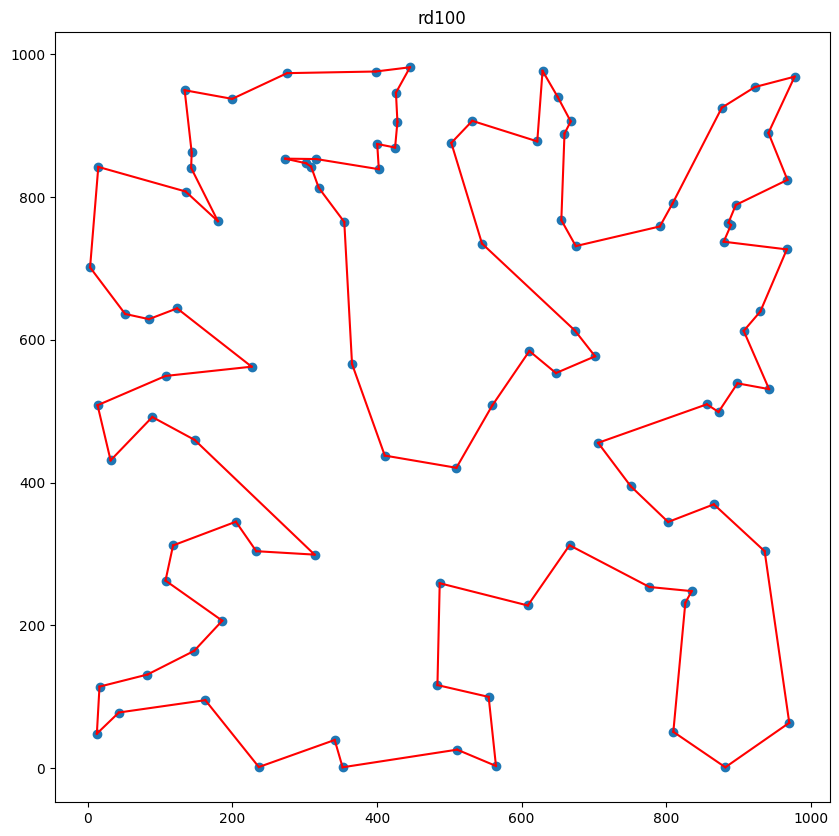

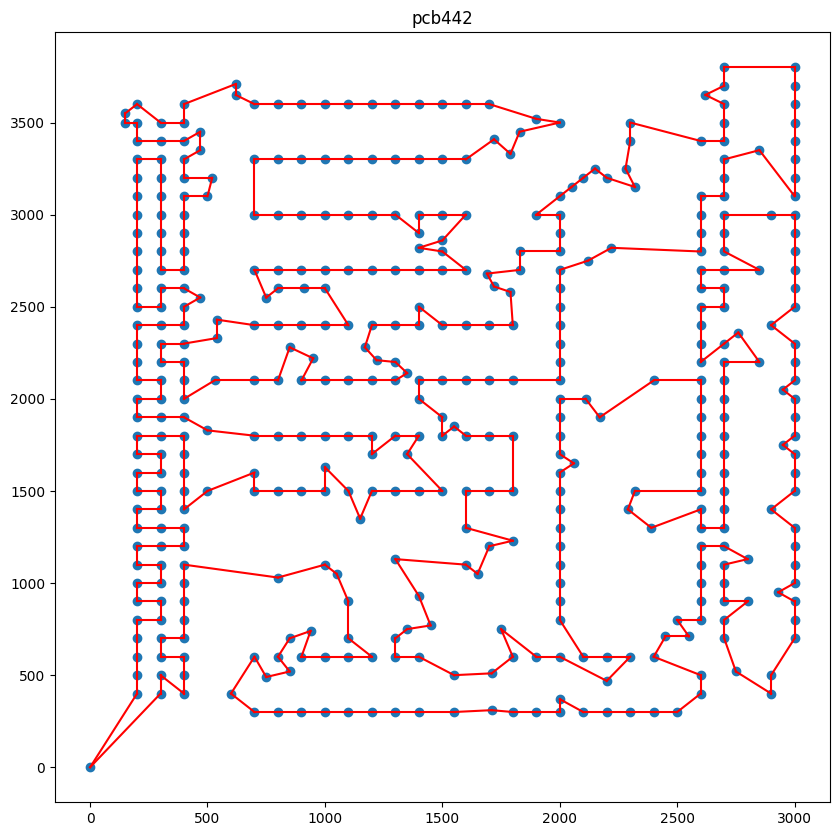

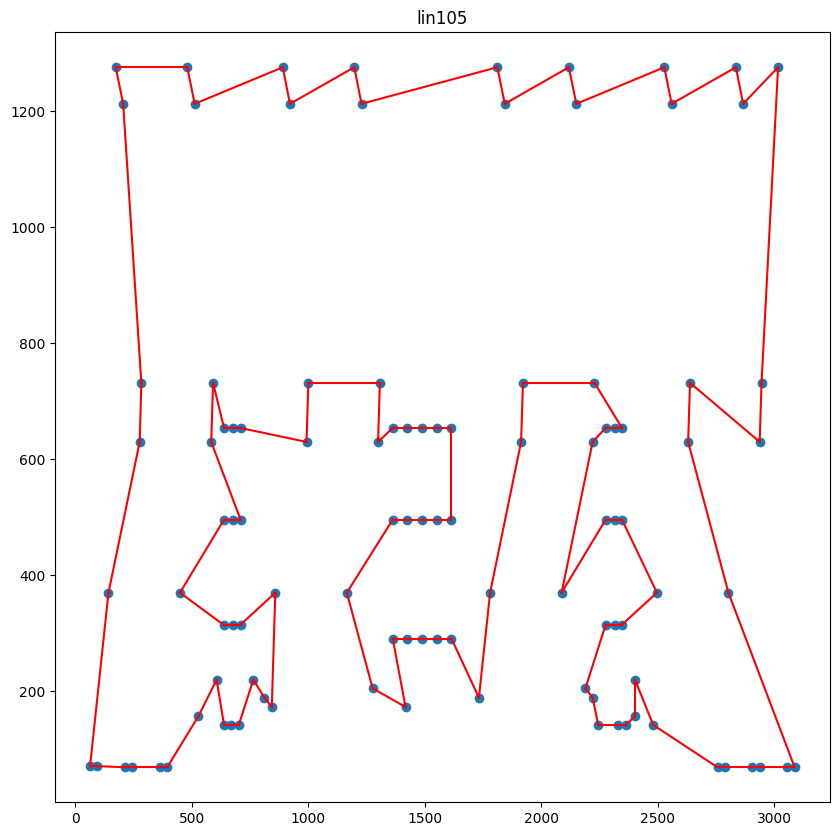

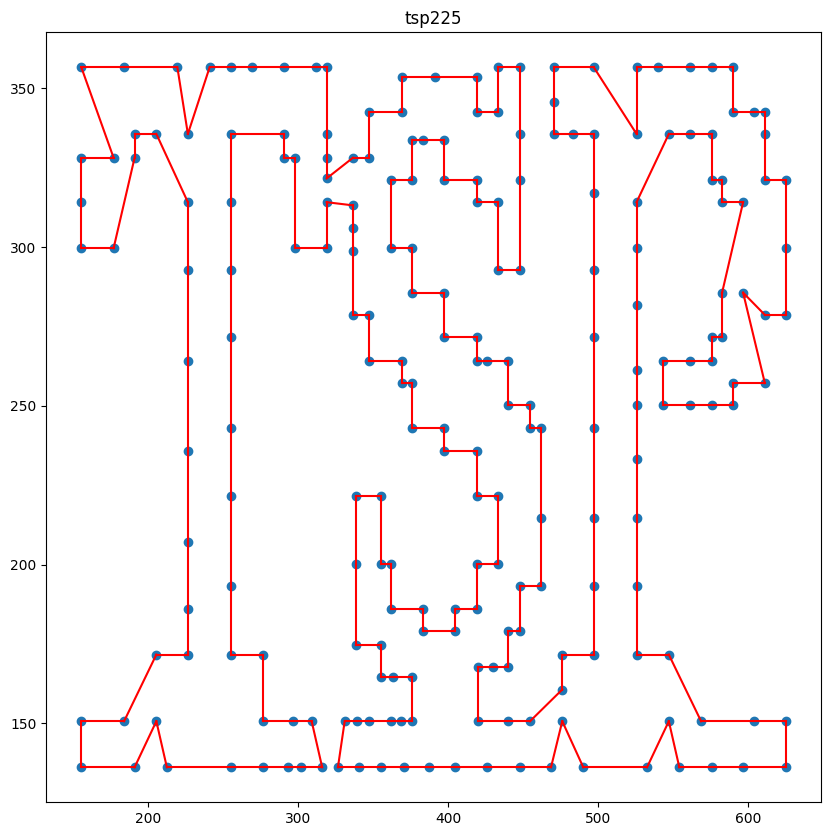

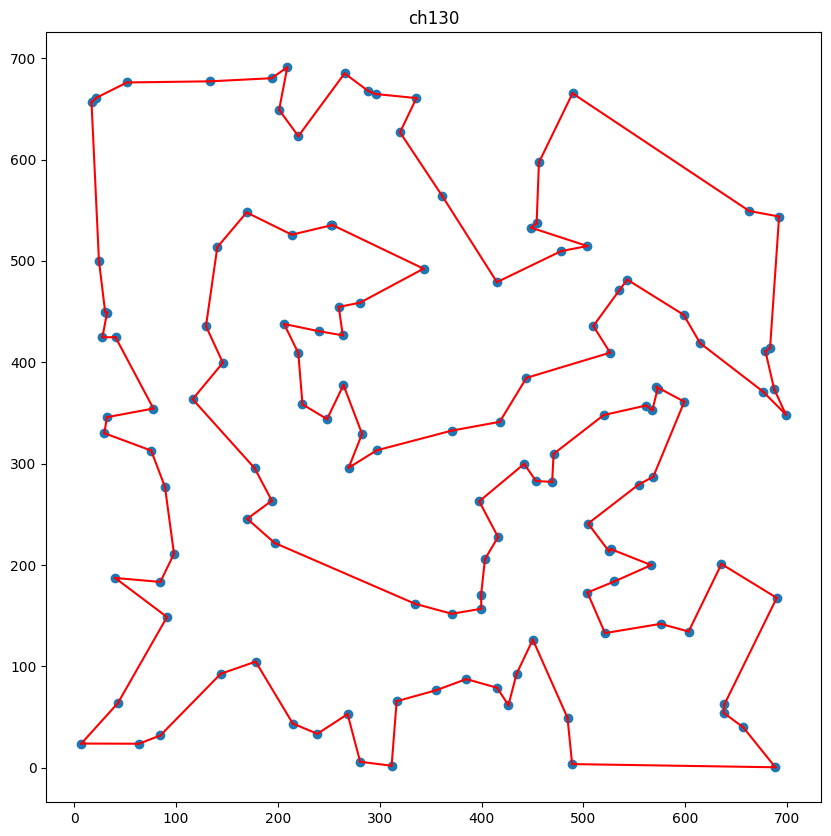

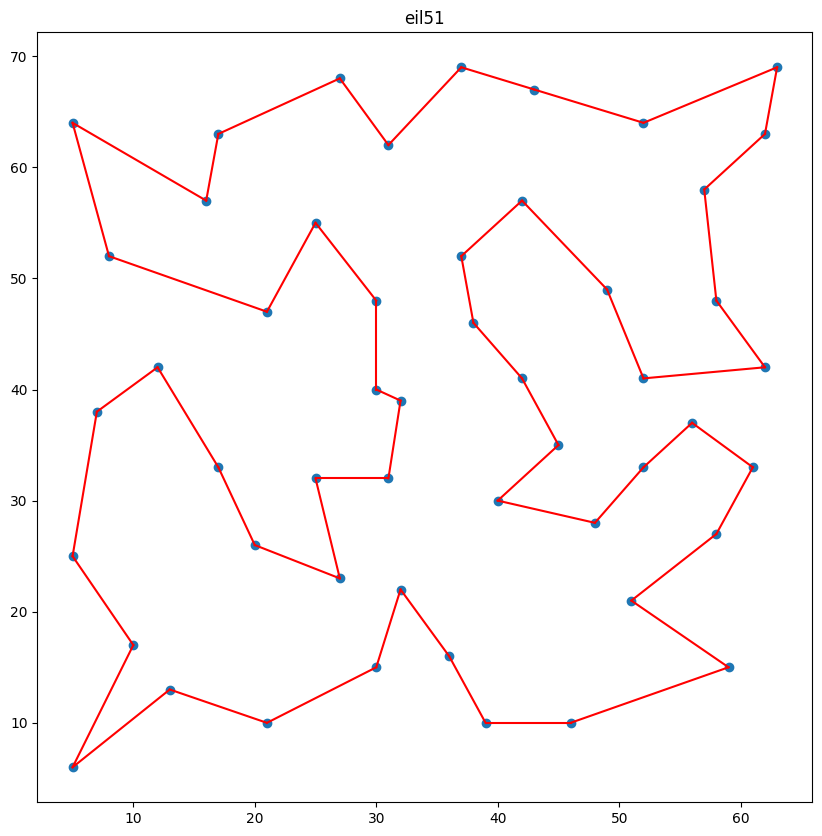

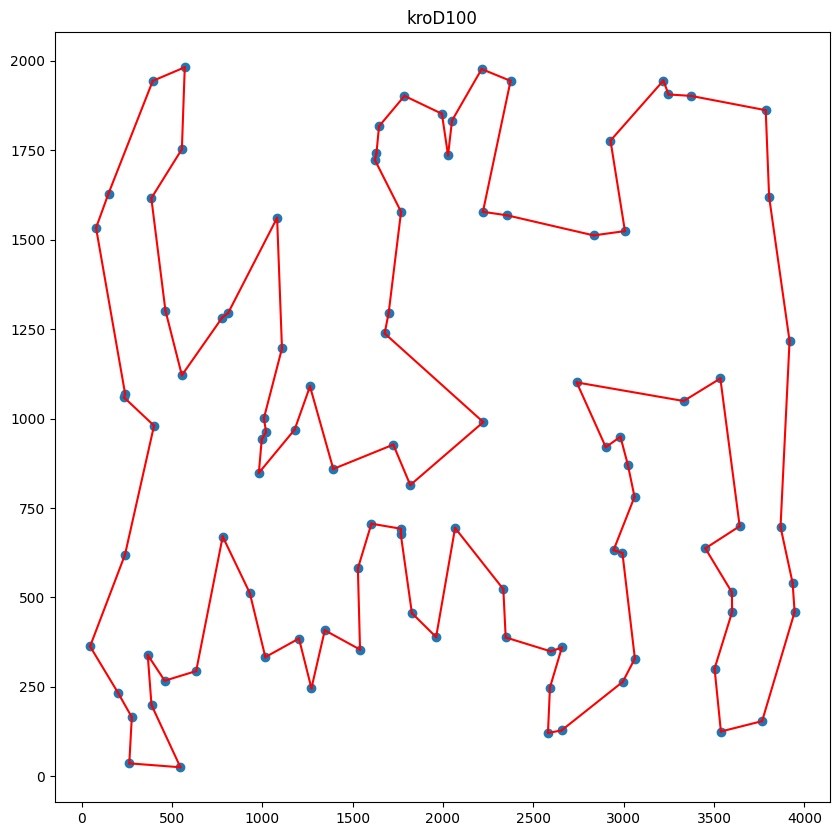

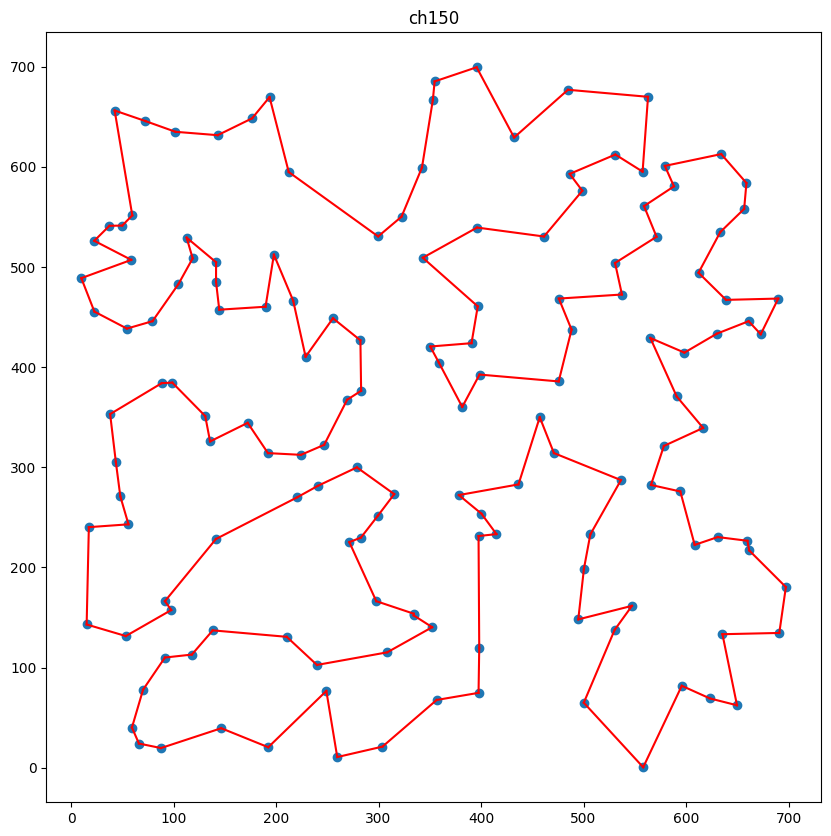

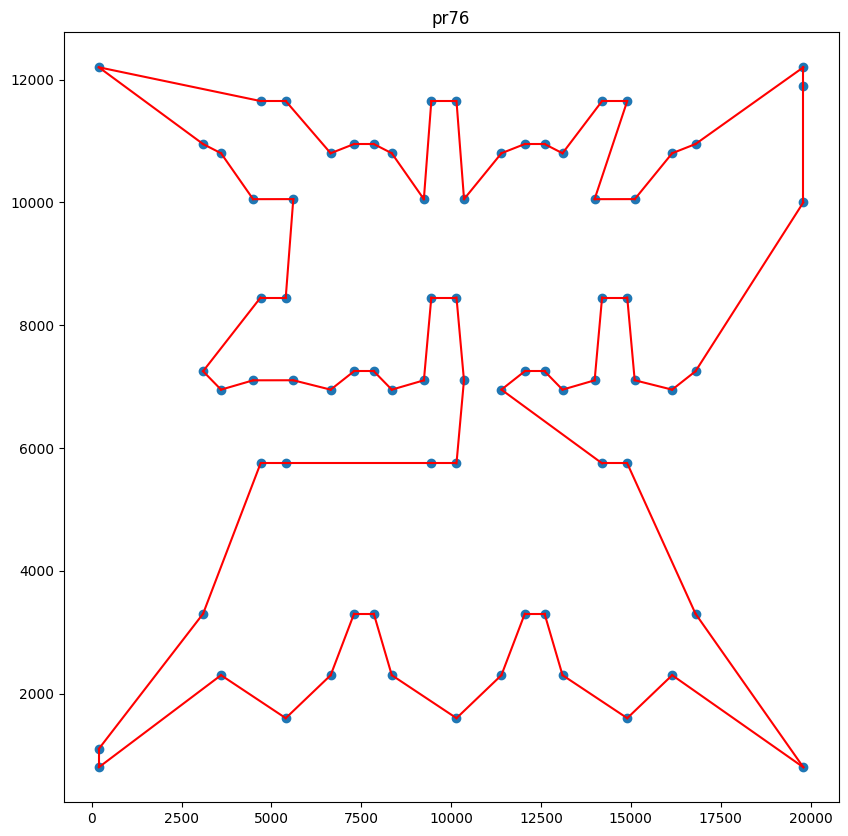

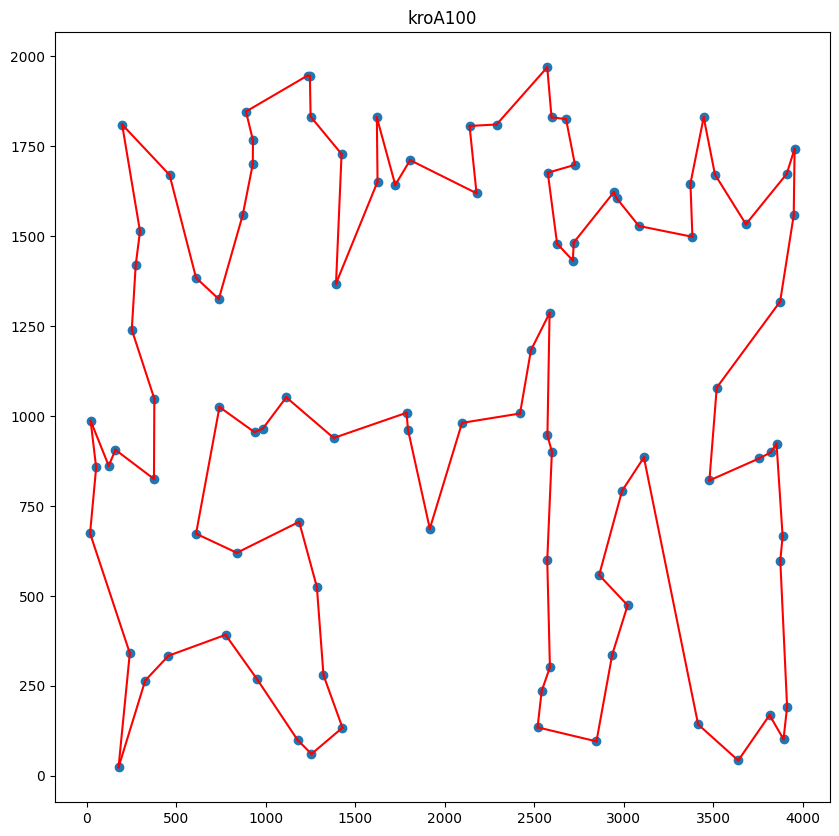

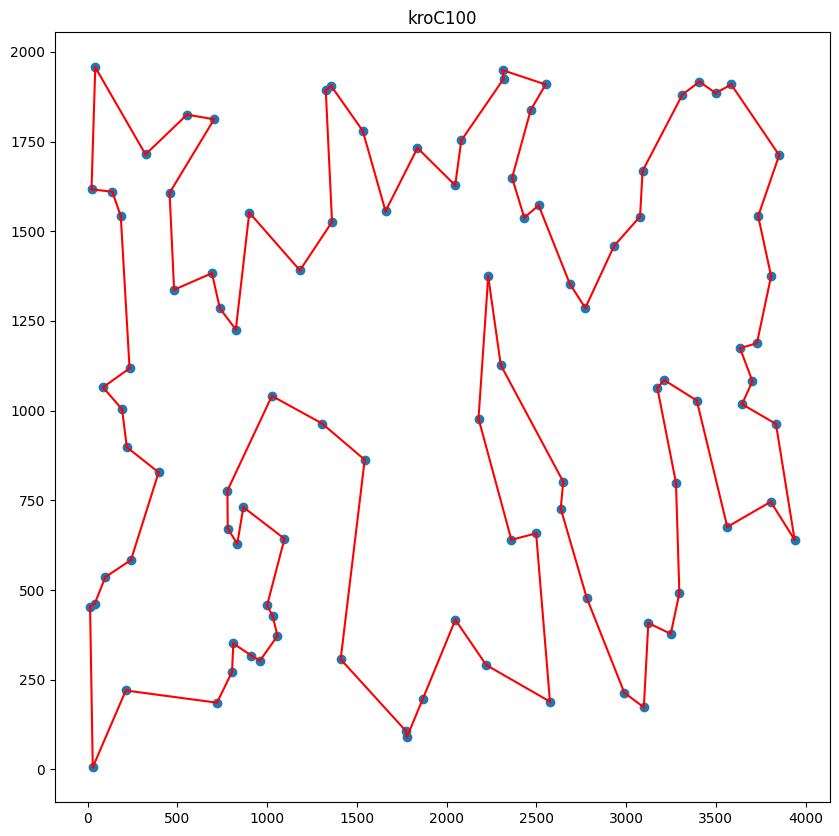

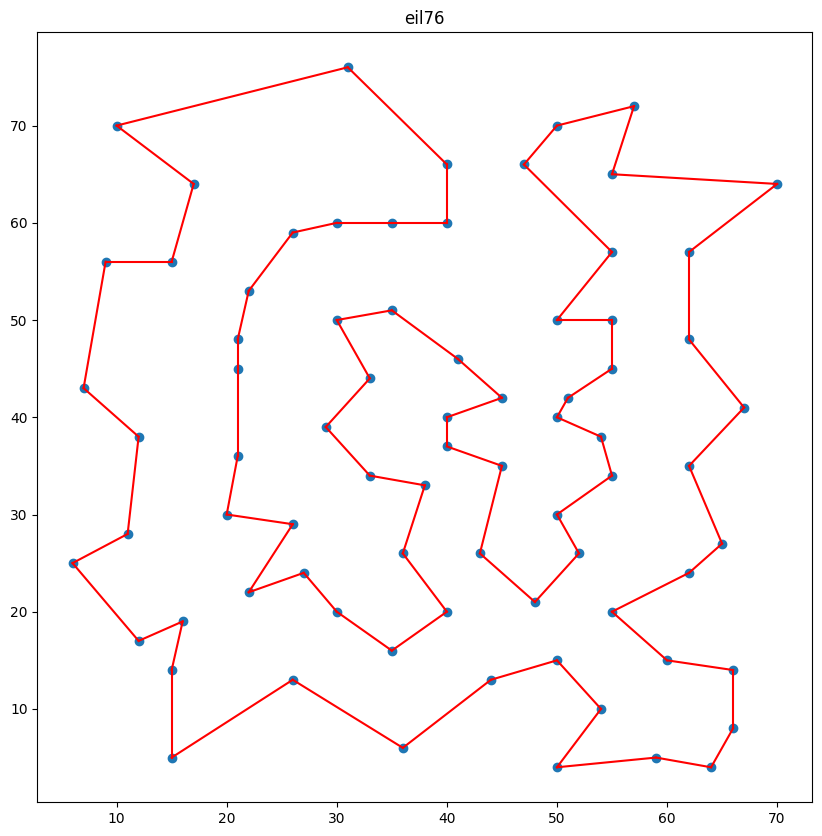

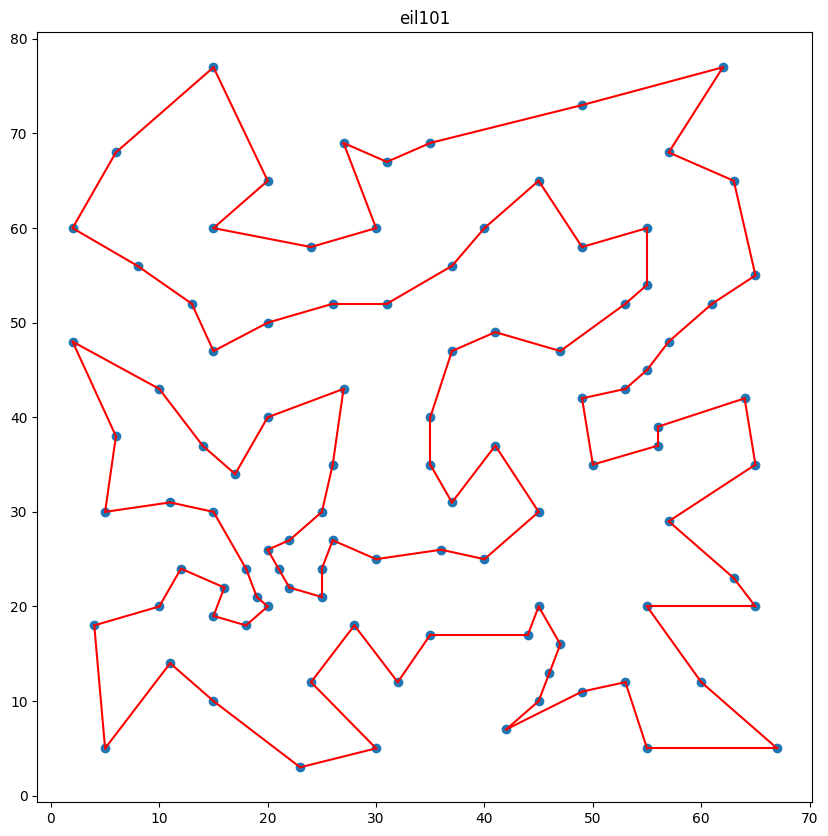

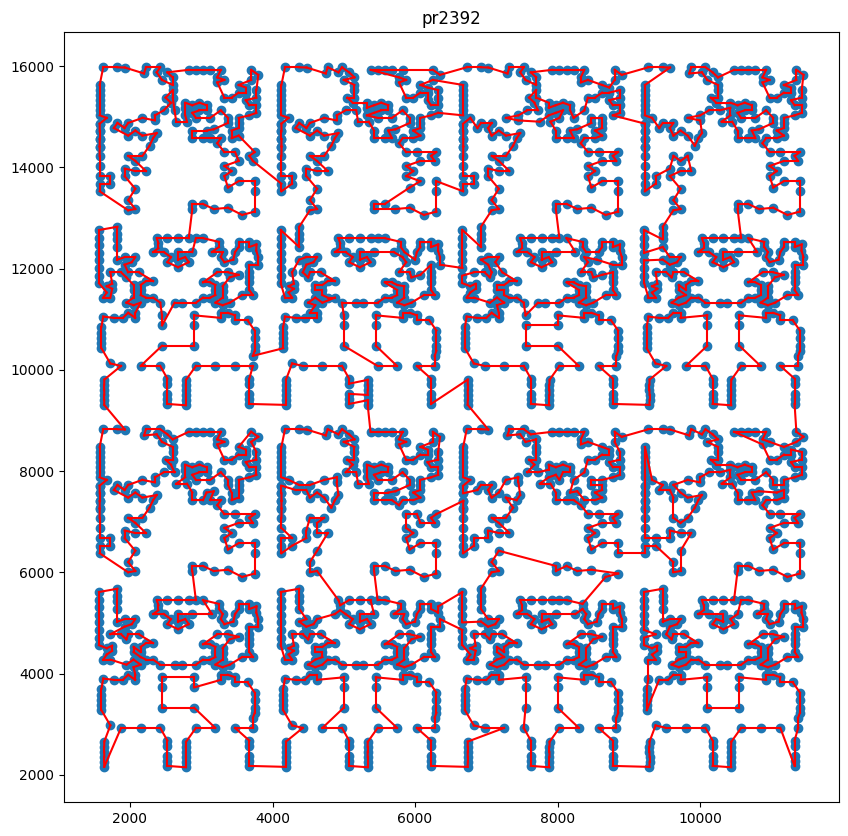

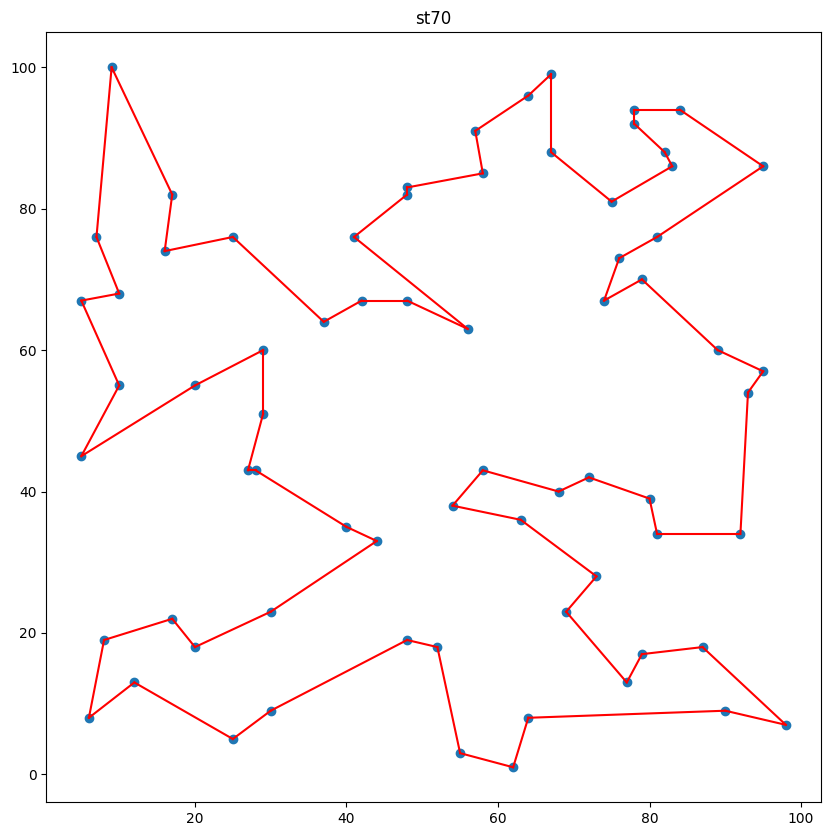

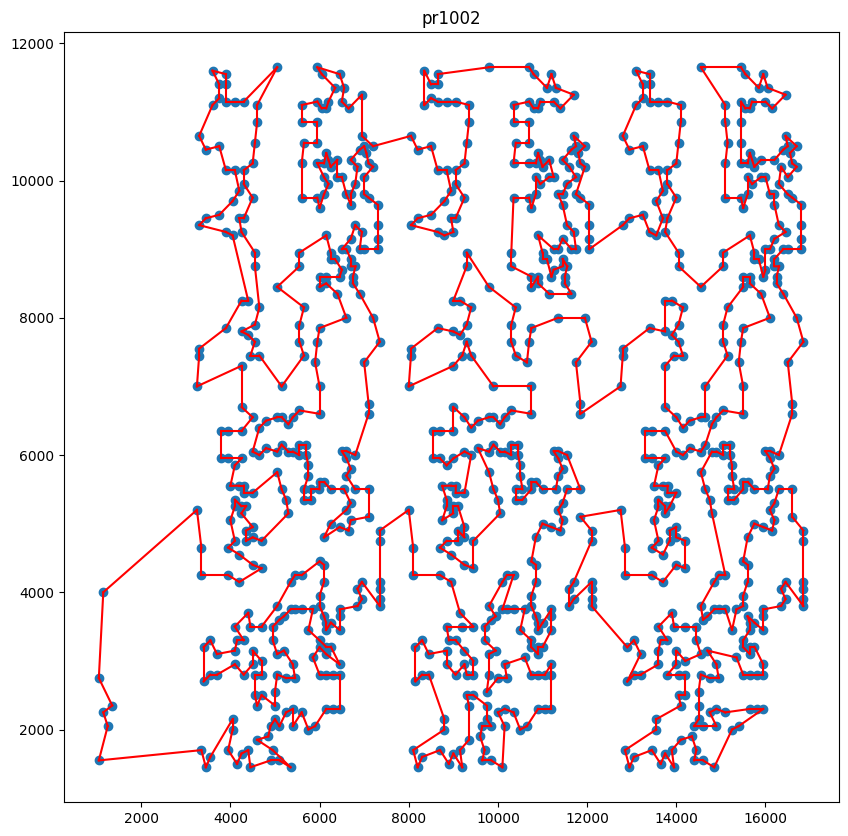

In [83]:
# Plot computed tours

for result in results:
    result.plot_tour()